_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [181]:
# Let's do our imports
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas_profiling
import seaborn as sns; sns.set()
import category_encoders as ce
import graphviz
from sklearn.tree import export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
%matplotlib inline

In [182]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

In [183]:
# Let's take a look
df.head(10)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,277,Stephen Curry,2,0,34,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,GSW,HOU,Regular Season,4.0
2009-10-28,20900015,413,Stephen Curry,4,10,26,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,GSW,HOU,Regular Season,-9.0
2009-10-28,20900015,453,Stephen Curry,4,6,31,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,GSW,HOU,Regular Season,-6.0
2009-10-28,20900015,487,Stephen Curry,4,2,25,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,GSW,HOU,Regular Season,-9.0


In [184]:
# Quick check for missing values
df.isna().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

In [186]:
# We need to separate our train, val and test dates
import datetime

df['Gamedate']=df.index

endball17 = datetime.date(2017,8,1)
startball17 = datetime.date(2017,10,1)
endball18 = datetime.date(2018,8,1)
startball18 = datetime.date(2018,10,1)
endball19 = datetime.date(2019,8,1)

# Ok, now let's set our date ranges
train = df[df['Gamedate'] <= endball17]
val = df[(df['Gamedate'] > startball17) & (df['Gamedate'] < endball18)]
test = df[(df['Gamedate'] > startball18) & (df['Gamedate'] < endball19)]

train.shape, val.shape, test.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raise

((11081, 20), (1168, 20), (1709, 20))

In [187]:
train.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,Gamedate
game_date,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0,2009-10-28
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0,2009-10-28
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0,2009-10-28
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0,2009-10-28
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0,2009-10-28


In [188]:
df['shot_zone_basic'].value_counts()

Above the Break 3        5695
Mid-Range                3194
Restricted Area          2692
In The Paint (Non-RA)    1250
Left Corner 3             603
Right Corner 3            428
Backcourt                  96
Name: shot_zone_basic, dtype: int64

In [189]:
df['shot_zone_range'].value_counts()

24+ ft.            6721
Less Than 8 ft.    3381
16-24 ft.          2440
8-16 ft.           1315
Back Court Shot     101
Name: shot_zone_range, dtype: int64

In [190]:
df['loc_x'].nunique()

493

In [191]:
# Now let's do some quick feature engineering
def organize(X):
    X = X.copy()
    
    # Let's make a list of the columns we can drop
    dupes = ['shot_type', 'shot_zone_range']
    meaningless=['player_name', 'game_id']
    
    # We'll combine minutes and seconds remaining into seconds remaining in period
    X['sec_remaining_period'] = (X['minutes_remaining'] * 60) + (X['seconds_remaining'])
    
    # and we'll also use the period column to find seconds remaining in game
    X['sec_remaining_game'] = ((4 - X['minutes_remaining']) * 720) + (X['sec_remaining_period'])
    
    # Add the now useless columns to our dupes list
    dupes = dupes + ['minutes_remaining', 'seconds_remaining']
    
    # Use htm and vtm to get both teams, the strip GSW
    X['opponent'] = X['htm'] + X['vtm']
    X['opponent'] = X['opponent'].str.strip('GSW')
    
    # Use htm and a lambda function to find home court advantage
    X['Homecourt_advantage'] = X['htm'].apply(lambda x: 1 if x == 'GSW' else 0)


    # Now we drop them
    todrop = dupes + meaningless
    X = X.drop(columns=todrop)
    
    return X

train = organize(train)
val = organize(val)
test = organize(test)

In [192]:
train.head()

,game_event_id,period,action_type,shot_zone_basic,shot_zone_area,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,Gamedate,sec_remaining_period,sec_remaining_game,opponent,Homecourt_advantage
game_date,,,,,,,,,,,,,,,,,,
2009-10-28,4,1,Jump Shot,Above the Break 3,Right Side Center(RC),26,99,249,0,GSW,HOU,Regular Season,2.0,2009-10-28,685,-4355,HOU,1
2009-10-28,17,1,Step Back Jump shot,Mid-Range,Left Side Center(LC),18,-122,145,1,GSW,HOU,Regular Season,0.0,2009-10-28,571,-3029,HOU,1
2009-10-28,53,1,Jump Shot,In The Paint (Non-RA),Center(C),14,-60,129,0,GSW,HOU,Regular Season,-4.0,2009-10-28,362,-1078,HOU,1
2009-10-28,141,2,Jump Shot,Mid-Range,Left Side(L),19,-172,82,0,GSW,HOU,Regular Season,-4.0,2009-10-28,589,-3011,HOU,1
2009-10-28,249,2,Jump Shot,Mid-Range,Left Side Center(LC),16,-68,148,0,GSW,HOU,Regular Season,0.0,2009-10-28,139,1579,HOU,1


In [200]:
# Let's set the target 
target = 'shot_made_flag'

# And a df with our train columns
trainfeats = train.drop(columns=[target, 'Gamedate'])

# We'll also separate the numeric features into one list...
numfeat = trainfeats.select_dtypes(include='number').columns.tolist()

# And the categorical features into one list...
catfeat = trainfeats.select_dtypes(exclude='number').columns.tolist()

# And we'll get the cardinality of the non-numeric features...
cardinality = trainfeat.select_dtypes(exclude='number').nunique()


feats = numfeat + catfeat


In [201]:
catfeat

['action_type',
 'shot_zone_basic',
 'shot_zone_area',
 'htm',
 'vtm',
 'season_type',
 'opponent']

In [202]:
numfeat

['game_event_id',
 'period',
 'shot_distance',
 'loc_x',
 'loc_y',
 'scoremargin_before_shot',
 'sec_remaining_period',
 'sec_remaining_game',
 'Homecourt_advantage']

In [203]:
cardinality.sort_values()

season_type         2
shot_zone_area      6
shot_zone_basic     7
htm                32
vtm                32
action_type        51
dtype: int64

In [204]:
len(feats)

16

In [205]:
# Now let's arrange our data into X features matrix and y target vector 
xtrain = train[feats]
ytrain = train[target]

xval = val[feats]
yval = val[target]

xtest = test[feats]
ytest = test[target]

# and get our baseline
majclass = ytrain.mode()[0]
ypred = [majclass]*len(ytrain)

baseline = accuracy_score(ytrain, ypred)
baseline

0.5272087356736757

In [206]:
# Now we have a baseline, we'll use a pipeline to get a better predictive model
pipeline = make_pipeline(
            ce.OrdinalEncoder(),
            RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1)
            )

# Fit on train, score on val, predict on test
pipeline.fit(xtrain, ytrain)
print('Train Acc:', pipeline.score(xtrain, ytrain))
print('Val Acc:', pipeline.score(xval, yval))

Train Acc: 0.7538128327768252
Val Acc: 0.6044520547945206


In [207]:
pipeline = make_pipeline(
            ce.OrdinalEncoder(),
            RandomForestClassifier(max_depth=12, n_estimators=100, random_state=42, n_jobs=-1)
            )

# Fit on train, score on val, predict on test
pipeline.fit(xtrain, ytrain)
print('Train Acc:', pipeline.score(xtrain, ytrain))
print('Val Acc:', pipeline.score(xval, yval))

Train Acc: 0.8129230213879614
Val Acc: 0.5941780821917808


In [210]:
pipeline = make_pipeline(
            ce.OrdinalEncoder(),
            RandomForestClassifier(max_depth=9, n_estimators=100, random_state=42, n_jobs=-1)
            )

# Fit on train, score on val, predict on test
pipeline.fit(xtrain, ytrain)
print('Train Acc:', pipeline.score(xtrain, ytrain))
print('Val Acc:', pipeline.score(xval, yval))

Train Acc: 0.7272809313238877
Val Acc: 0.6095890410958904


In [213]:
# Now we can find predict on test to find our test Accuracy
ypred = pipeline.predict(xtest)
print('Test Acc:', accuracy_score(ypred, ytest))

Test Acc: 0.6190754827384435


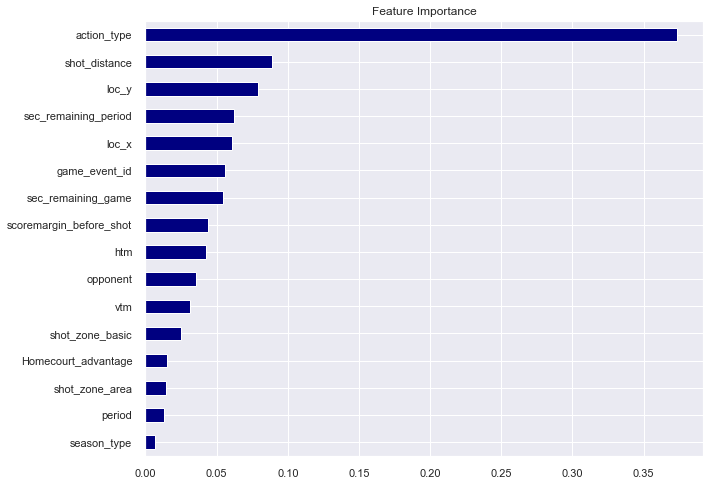

In [214]:
# Now let's get the feature importances
encoder  = pipeline.named_steps['ordinalencoder']
forest = pipeline.named_steps['randomforestclassifier']

featnames = encoder.transform(xval).columns
importances = pd.Series(forest.feature_importances_, featnames)

# And let's plot them
n = 16
plt.figure(figsize=(10, n/2))
plt.title('Feature Importance')
importances.sort_values()[-n:].plot.barh(color='navy');

### For the imaginary confusion matrix below:
- **Accuracy** = (85 + 36) / 187 = **.647**
- **Negative Precision** = 85 / 93 = **.914**
- **Negative Recall** = 85 / 143 = **.594**
- **Positive Precision** = 36 / 94 = **.383**
- **Positive Recall** = 36 / 44 = **.818**

### For the imaginary confusion matrix below:
- **Negative F1 Score** = 2 * (.914 * .594) / (.914 + .594) = **.720**
- **Positive F1 Score** = 2 * (.383 * .818) / (.383 + .818) = **.522**

In [215]:
ypred = pipeline.predict(xval)

from sklearn.metrics import confusion_matrix

cmatrix = confusion_matrix (yval, ypred)
cmatrix

array([[368, 235],
       [221, 344]], dtype=int64)

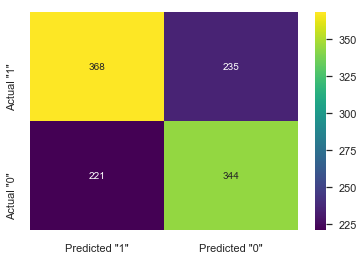

In [216]:
columns = [f'Predicted "{c}"' for c in yval.unique()]
indices = [f'Actual "{c}"' for c in yval.unique()]

cmdf = pd.DataFrame(cmatrix, columns=columns, index=indices)

sns.heatmap(cmdf, cmap='viridis', annot=True, fmt='d')

In [218]:
from sklearn.metrics import classification_report

print(classification_report(yval, ypred))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62       603
           1       0.59      0.61      0.60       565

   micro avg       0.61      0.61      0.61      1168
   macro avg       0.61      0.61      0.61      1168
weighted avg       0.61      0.61      0.61      1168



This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.